In [561]:
import matplotlib as plt
import pandas as pd
import os
import csv
from datetime import datetime

def filter(df,column, value):
    indexNames = df[ (df[column] != value)].index
    df.drop(indexNames , inplace=True)
    df = df.reset_index(drop=True)
    return df

# def screnarioIndex():

def getInfoFromFilename(file, fileNumber):
        tokenList = statFiles[fileNumber].split(' - ')
        tokenList[2] = tokenList[2][:-10]
        while len(tokenList) > 2:
            tokenList.pop(1)
            
        tokenList[-1] = datetime(int(tokenList[-1][0:4]), int(tokenList[-1][5:7]), int(tokenList[-1][8:10]), hour = int(tokenList[-1][11:13]), minute = int(tokenList[-1][14:16]), second = int(tokenList[-1][17:19]))
        
        return tokenList

def graph(df,graphType, title, x_ticks, y_label, size_x, size_y):
    ax = df.plot(kind=graphType, linewidth="4",figsize = (size_x, size_y), xticks=x_ticks)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    return ax

In [622]:
class Scenario:    
    def __init__(self, name):
        self.name = name
        self.scores = {}
        self.topScores = {}
        self.avgScores = {}
        self.keyList = []
        self.df = None
        self.datesCount = {}
        self.datesList = []
    
    def addScoreFromFilename(self, timestamp, score):
        if not isinstance(timestamp, datetime):
            raise Exception('Error: Timestamp is not a datetime obect.')
        if not (isinstance(score, float) or isinstance(score, int)):
            raise Exception('Error: Score is not a float.')
        
        self.scores[timestamp] = score
        
        # Technically should be binary searching and inserting at the proper point, but this works for now
        self.keyList.append(timestamp)
        self.keyList.sort()
        
    def generateDataframe(self, valueType='top', date=None):        
        if valueType == 'top':
            self.getDates()
            if len(self.datesList) > 1:
                i = 0
                for date in self.datesList:
                    key = self.keyList[i]
                    lastKey = key
                    topScore = self.scores[key]
                    while date == key.date():
                        if self.scores[key] > topScore:
                            topScore = self.scores[key]

                        i+=1
                        if i < len(self.keyList):
                            lastKey = key
                            key = self.keyList[i]
                        else:
                            key = datetime(1, 1, 1)
                            
                    self.topScores[lastKey.date()] = topScore

#                 print('{}\n{}\n\n'.format(self.name, self.topScores))
                self.df = pd.DataFrame(self.topScores.items(), columns=['Date', 'Score'])
                self.df.set_index('Date', inplace = True)
            else:
#                 print("{}: Can not generate top scores graph from only one day of data.\n".format(self.name))
                return None
        elif valueType == 'avg':
            self.getDates()
            if len(self.datesList) > 1:
                print(self.name)
                i = 0
                for date in self.datesList:
                    print('------')
                    key = self.keyList[i]
                    lastKey = key
                    avgScore = 0
                    while date == key.date():
                        avgScore += self.scores[key]
                        print('{} : {}'.format(key, avgScore))

                        i+=1
                        if i < len(self.keyList):
                            lastKey = key
                            key = self.keyList[i]
                        else:
                            key = datetime(1, 1, 1)
                            
                    self.avgScores[lastKey.date()] = avgScore / self.datesCount[date]
                    print('-------------------------------{}'.format(self.datesCount[date]))

                print('{}\n{}\n\n'.format(self.name, self.avgScores))
                self.df = pd.DataFrame(self.avgScores.items(), columns=['Date', 'Score'])
                self.df.set_index('Date', inplace = True)
            else:
#                 print("{}: Can not generate top scores graph from only one day of data.\n".format(self.name))
                return None
#         else if valueType == 'day':
#             if day == None:
#                 raise Exception('Error: If valueType is \'day\' then a date must be given.')
#         else:
#             raise Exception('Error: valueType must be either \'top\', \'avg\' or \'day\'.')
        return self.df
    
    def getDates(self):
        for key in self.datesCount:
            self.datesCount[key] = 0
        for key in self.keyList:
            keyDate = key.date()
            if not keyDate in self.datesList:
                self.datesCount[keyDate] = 1
                self.datesList.append(keyDate)
            else:
                self.datesCount[keyDate] += 1
                
        self.datesList.sort()
        return self.datesList

In [623]:
STATS_DIRECTORY = 'C:\ProgramData\SteamLibrary\steamapps\common\FPSAimTrainer\FPSAimTrainer\stats'

statFiles = []
for root, _, files in os.walk(STATS_DIRECTORY):
    for file in files:
        if file.endswith('.csv'):
            statFiles.append(file)

In [624]:
scenarioList = []
for fileNumber in range(0, len(statFiles)):    
    df = pd.read_csv(STATS_DIRECTORY + '\\' +  statFiles[fileNumber], sep=',', error_bad_lines=False)
    
    df.rename(columns={'Kill #':'Headings'}, inplace=True)
    df.rename(columns={'Timestamp':'Values'}, inplace=True)

    df = df[['Headings','Values']]
    df = filter(df, 'Headings', 'Score:')
        
    name, timestamp = getInfoFromFilename(statFiles[fileNumber], fileNumber)
    
    scenarioNumber = -1
    index = 0
    for scenario in scenarioList:
        if scenario.name == name:
            scenarioNumber = index
            break
        index += 1

    if scenarioNumber == -1:
        scenarioList.append(Scenario(name))
    
    try:
        scenarioList[scenarioNumber].addScoreFromFilename(timestamp, float(df["Values"].iloc[-1]))
    except IndexError: # Thrown when there are no recorded kills, causing the auto df columns to be empty
        with open(STATS_DIRECTORY + '\\' + statFiles[fileNumber],'r') as originalCSV:
            with open("fixed.csv",'w') as newCSV:
                next(originalCSV) # skip header line
                next(originalCSV) # skip header line
                for line in originalCSV:
                    newCSV.write(line)
                    
        df = pd.read_csv('fixed.csv', sep=',', error_bad_lines=False)

        df.rename(columns={'Weapon':'Headings'}, inplace=True)
        df.rename(columns={'Shots':'Values'}, inplace=True)

        df = df[['Headings','Values']]
        df = filter(df, 'Headings', 'Score:')
        scenarioList[scenarioNumber].addScoreFromFilename(timestamp, float(df["Values"].iloc[-1]))
                
# for scenario in scenarioList:
#     print(scenario.name)
# #     scenario.sortScores()
#     for line in scenario.keyList:
#         print('{} : {}'.format(line, scenario.scores[line]))
#     print('\n\n\n')


b'Skipping line 92: expected 12 fields, saw 16\n'
b'Skipping line 85: expected 12 fields, saw 16\n'
b'Skipping line 84: expected 12 fields, saw 16\n'
b'Skipping line 66: expected 12 fields, saw 16\nSkipping line 67: expected 12 fields, saw 17\n'
b'Skipping line 68: expected 12 fields, saw 16\nSkipping line 69: expected 12 fields, saw 17\n'
b'Skipping line 65: expected 12 fields, saw 16\nSkipping line 66: expected 12 fields, saw 17\n'
b'Skipping line 66: expected 12 fields, saw 16\nSkipping line 67: expected 12 fields, saw 17\n'
b'Skipping line 64: expected 12 fields, saw 16\nSkipping line 65: expected 12 fields, saw 17\n'
b'Skipping line 69: expected 12 fields, saw 16\nSkipping line 70: expected 12 fields, saw 17\n'
b'Skipping line 67: expected 12 fields, saw 16\nSkipping line 68: expected 12 fields, saw 17\n'
b'Skipping line 62: expected 12 fields, saw 16\nSkipping line 63: expected 12 fields, saw 17\n'
b'Skipping line 66: expected 12 fields, saw 16\nSkipping line 67: expected 12 fiel

b'Skipping line 80: expected 12 fields, saw 16\n'
b'Skipping line 82: expected 12 fields, saw 16\n'
b'Skipping line 78: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'
b'Skipping line 81: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'
b'Skipping line 82: expected 12 fields, saw 16\n'
b'Skipping line 75: expected 12 fields, saw 16\n'
b'Skipping line 87: expected 12 fields, saw 16\n'
b'Skipping line 73: expected 12 fields, saw 16\n'
b'Skipping line 77: expected 12 fields, saw 16\n'
b'Skipping line 75: expected 12 fields, saw 16\n'
b'Skipping line 84: expected 12 fields, saw 16\n'
b'Skipping line 82: expected 12 fields, saw 16\n'
b'Skipping line 88: expected 12 fields, saw 16\n'
b'Skipping line 82: expected 12 fields, saw 16\n'
b'Skipping line 82: expected 12 fields, saw 16\n'
b'Skipping line 79: expected 12 fields, saw 16\n'
b'Skipping line 87: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'


b'Skipping line 43: expected 12 fields, saw 16\n'
b'Skipping line 78: expected 12 fields, saw 16\n'
b'Skipping line 73: expected 12 fields, saw 16\n'
b'Skipping line 79: expected 12 fields, saw 16\n'
b'Skipping line 72: expected 12 fields, saw 16\n'
b'Skipping line 73: expected 12 fields, saw 16\n'
b'Skipping line 73: expected 12 fields, saw 16\n'
b'Skipping line 80: expected 12 fields, saw 16\n'
b'Skipping line 88: expected 12 fields, saw 16\n'
b'Skipping line 75: expected 12 fields, saw 16\n'
b'Skipping line 79: expected 12 fields, saw 16\n'
b'Skipping line 88: expected 12 fields, saw 16\n'
b'Skipping line 88: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'
b'Skipping line 89: expected 12 fields, saw 16\n'
b'Skipping line 77: expected 12 fields, saw 16\n'
b'Skipping line 94: expected 12 fields, saw 16\n'
b'Skipping line 88: expected 12 fields, saw 16\n'
b'Skipping line 83: expected 12 fields, saw 16\n'


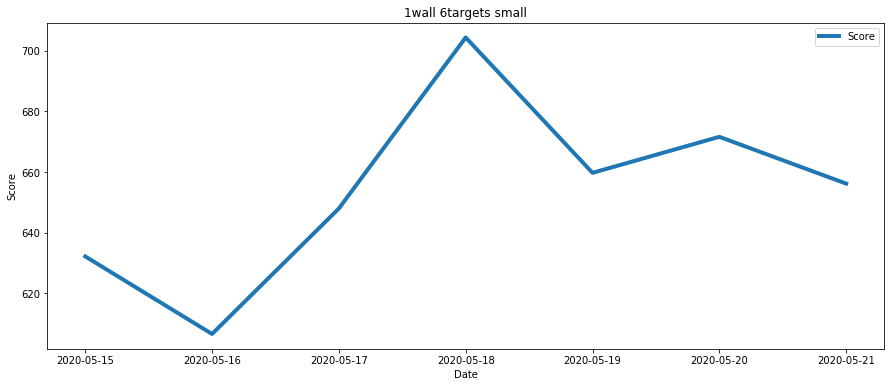

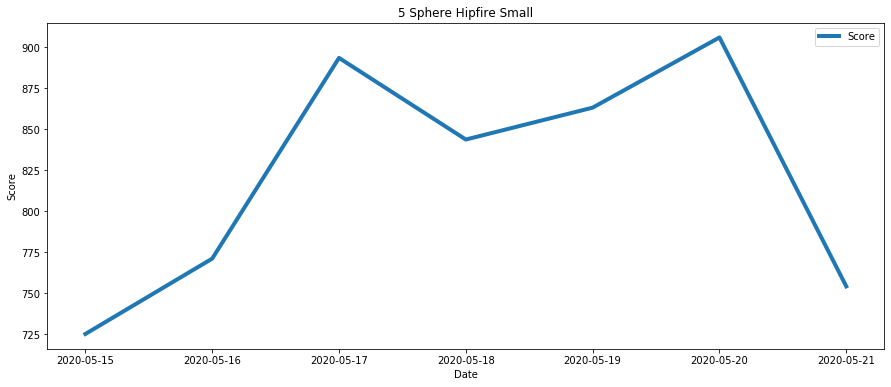

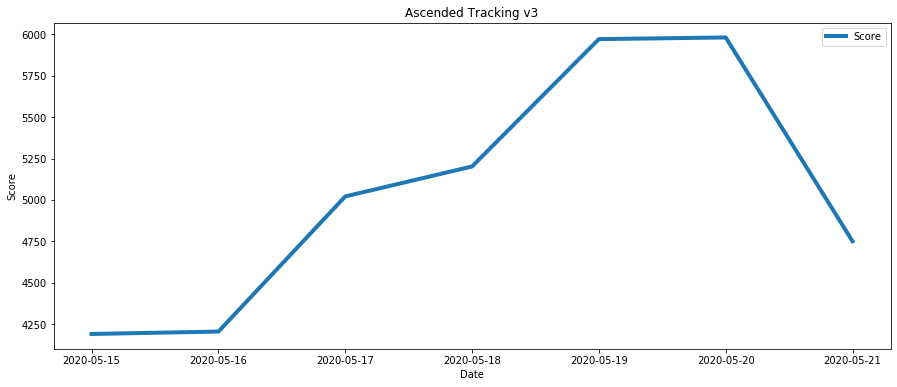

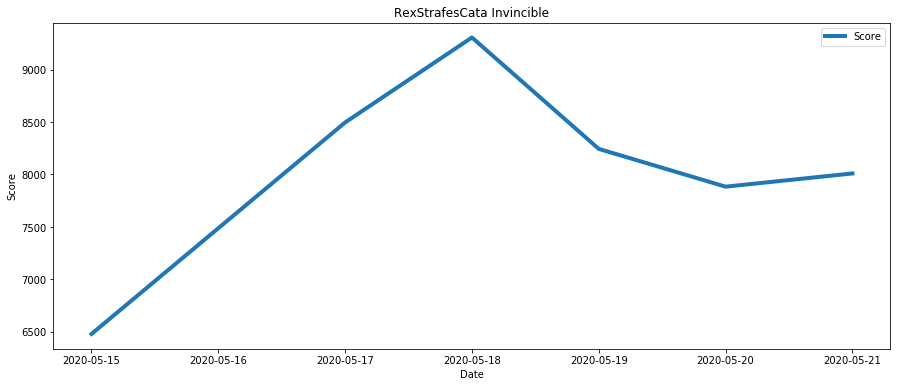

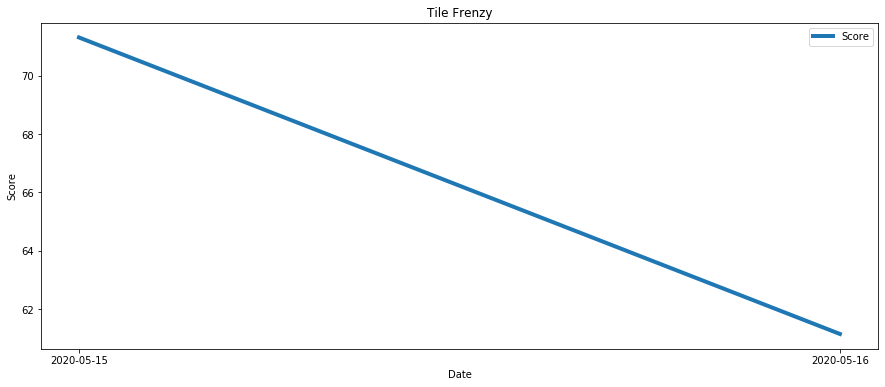

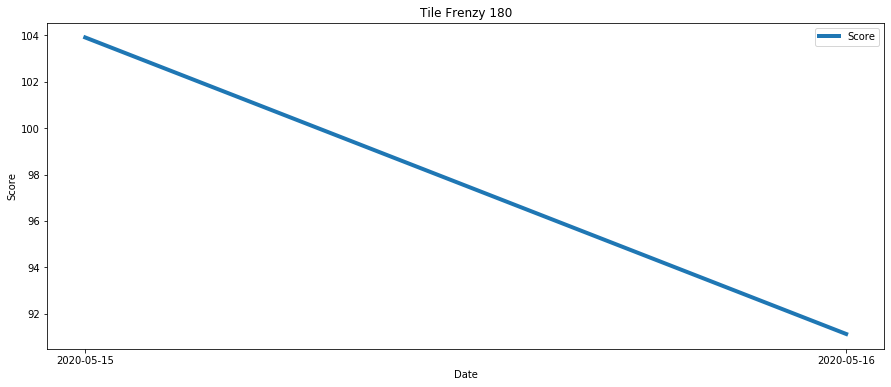

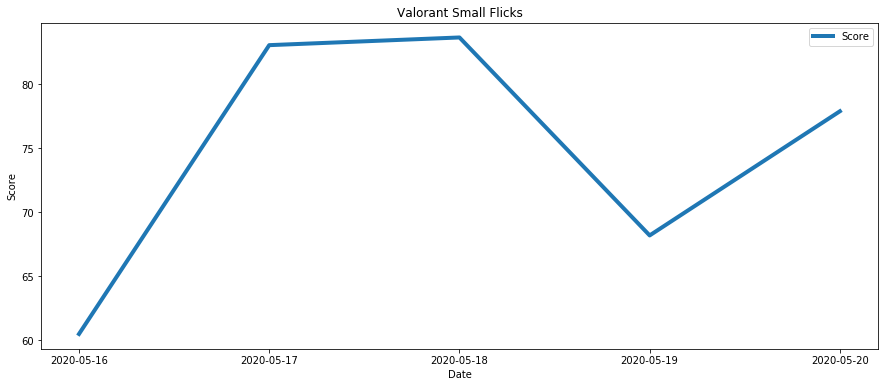

In [615]:
for scenario in scenarioList:
    df = scenario.generateDataframe()
    if not df is None:
        graph(df, 'line', scenario.name, scenario.datesList, 'Score', 15, 6)

In [ ]:
i = 0
for scenario in scenarioList:
    print('{:>2}: {}'.format(i, scenario.name))
    i+=1

1wall 6targets small
------
2020-05-15 12:23:14 : 853.5484
2020-05-15 12:24:20 : 1350.607238
2020-05-15 12:57:49 : 1782.517364
2020-05-15 12:59:05 : 2228.472412
2020-05-15 13:16:32 : 2661.14682
2020-05-15 13:17:37 : 3134.625091
2020-05-15 13:44:23 : 3605.429687
2020-05-15 13:45:27 : 3960.633789
2020-05-15 14:58:17 : 4353.604095
2020-05-15 14:59:21 : 4798.821502
2020-05-15 15:13:30 : 5245.798248
2020-05-15 15:14:34 : 5755.911865
2020-05-15 15:27:58 : 6230.630981
2020-05-15 15:29:02 : 6644.075408000001
2020-05-15 15:56:00 : 7200.893584
2020-05-15 15:57:06 : 7700.405761
2020-05-15 15:58:10 : 8332.60089
2020-05-15 15:59:27 : 8803.405486
2020-05-15 16:00:29 : 9391.183257
2020-05-15 22:01:45 : 9880.621459
2020-05-15 22:02:49 : 10505.199767
-------------------------------21
------
2020-05-16 11:16:53 : 1213.243286
2020-05-16 11:18:00 : 1786.4011839999998
-------------------------------2
------
2020-05-17 12:07:26 : 1170.285766
2020-05-17 12:08:32 : 1783.806884
2020-05-17 12:09:35 : 2317.77514

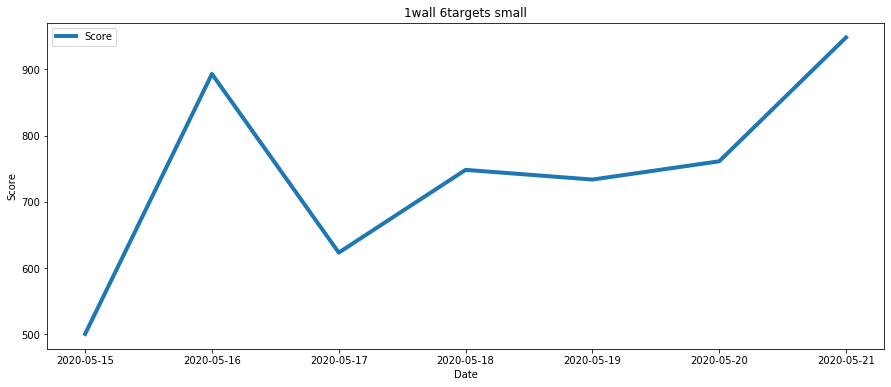

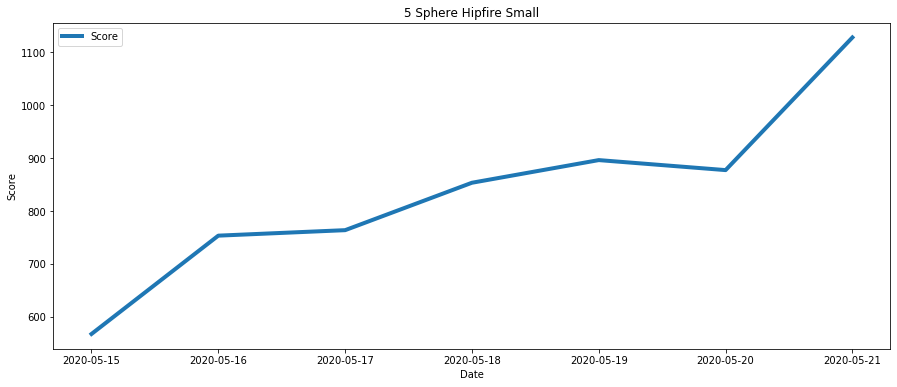

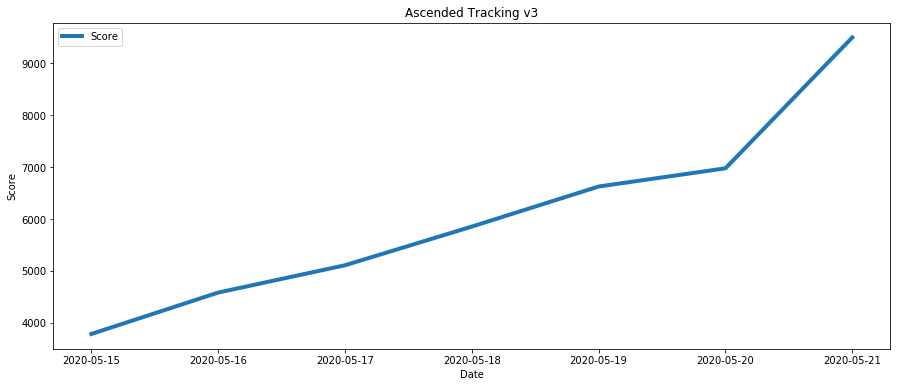

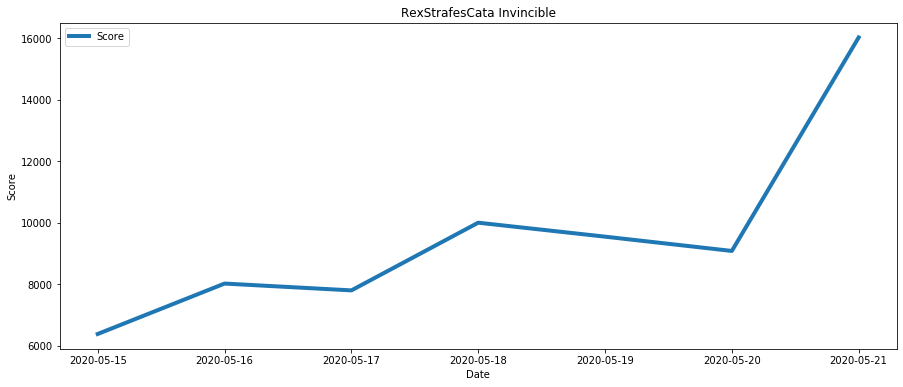

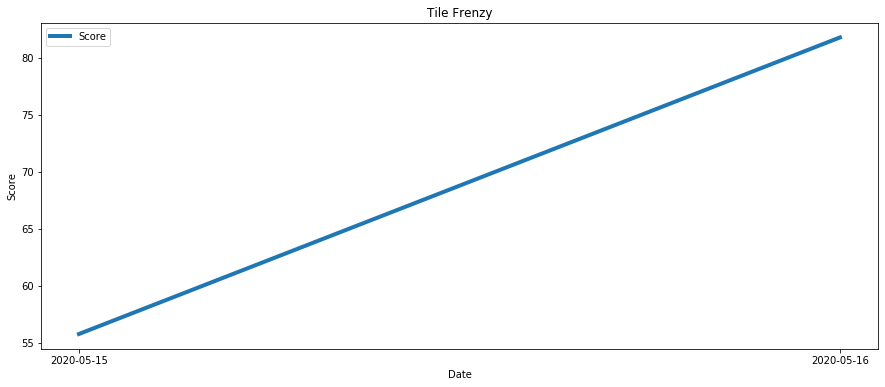

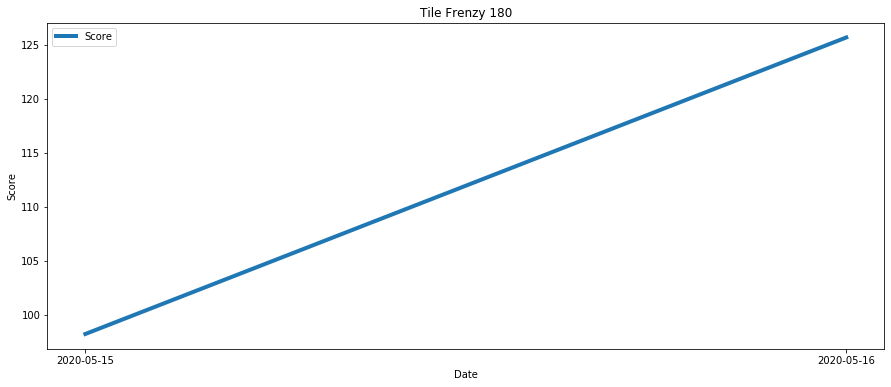

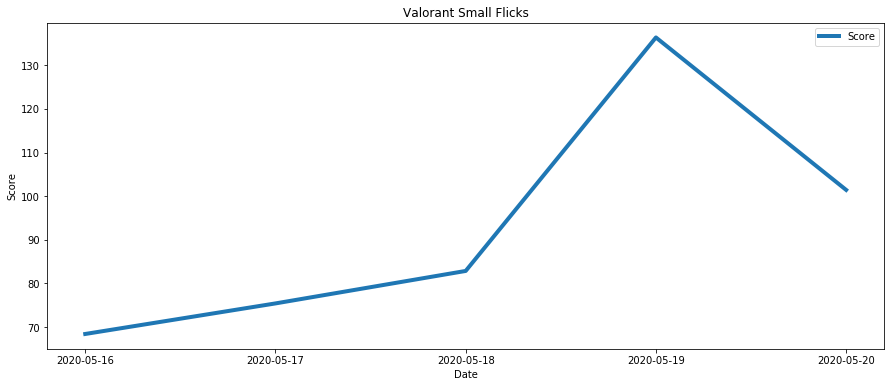

In [621]:
for scenario in scenarioList:
    df = scenario.generateDataframe(valueType = 'avg')
    if not df is None:
        graph(df, 'line', scenario.name, scenario.datesList, 'Score', 15, 6)

1wall 6targets small
------
2020-05-15 12:23:14 : 426.7742
2020-05-15 12:24:20 : 923.833038
2020-05-15 12:57:49 : 1355.743164
2020-05-15 12:59:05 : 1801.698212
2020-05-15 13:16:32 : 2234.37262
2020-05-15 13:17:37 : 2707.850891
2020-05-15 13:44:23 : 3178.655487
2020-05-15 13:45:27 : 3533.859589
2020-05-15 14:58:17 : 3926.8298950000003
2020-05-15 14:59:21 : 4372.047302
2020-05-15 15:13:30 : 4819.024048
2020-05-15 15:14:34 : 5329.137665
2020-05-15 15:27:58 : 5803.856781
2020-05-15 15:29:02 : 6217.301208000001
2020-05-15 15:56:00 : 6774.1193840000005
2020-05-15 15:57:06 : 7273.631561
2020-05-15 15:58:10 : 7905.82669
2020-05-15 15:59:27 : 8376.631286
2020-05-15 16:00:29 : 8964.409057
2020-05-15 22:01:45 : 9453.847259
2020-05-15 22:02:49 : 10078.425567
-------------------------------21
------
2020-05-16 11:16:53 : 606.621643
2020-05-16 11:18:00 : 1179.7795409999999
-------------------------------2
------
2020-05-17 12:07:26 : 585.142883
2020-05-17 12:08:32 : 1198.664001
2020-05-17 12:09:35 :

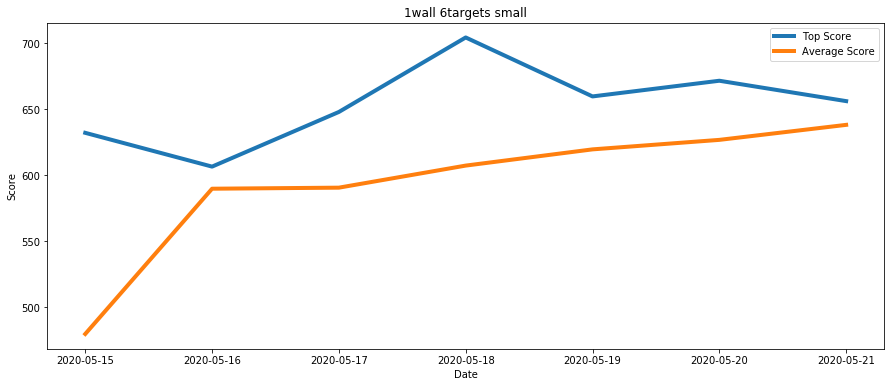

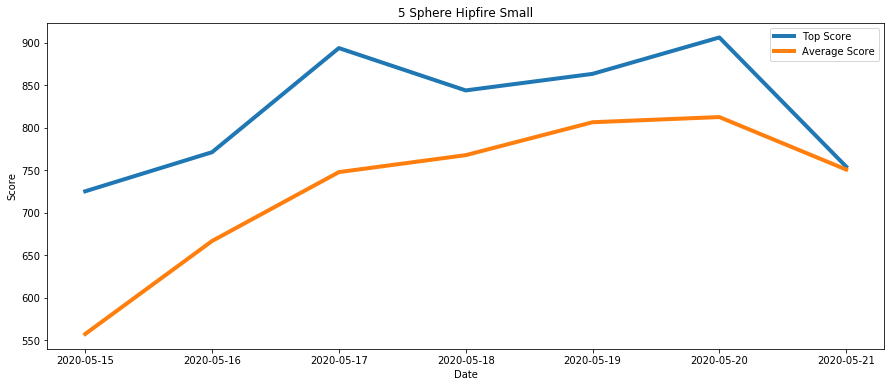

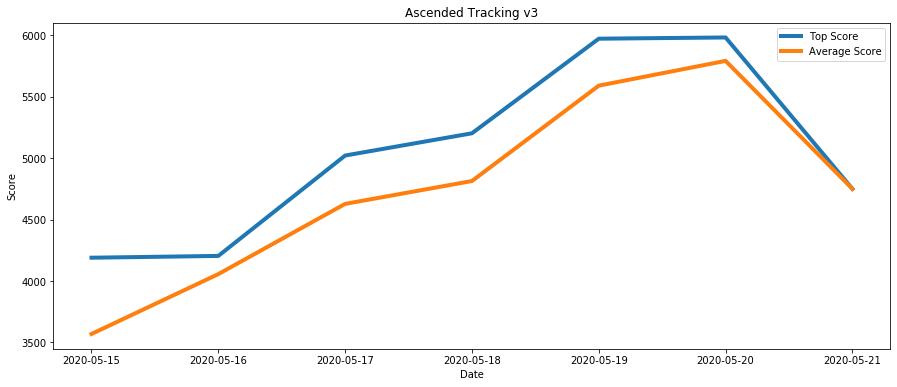

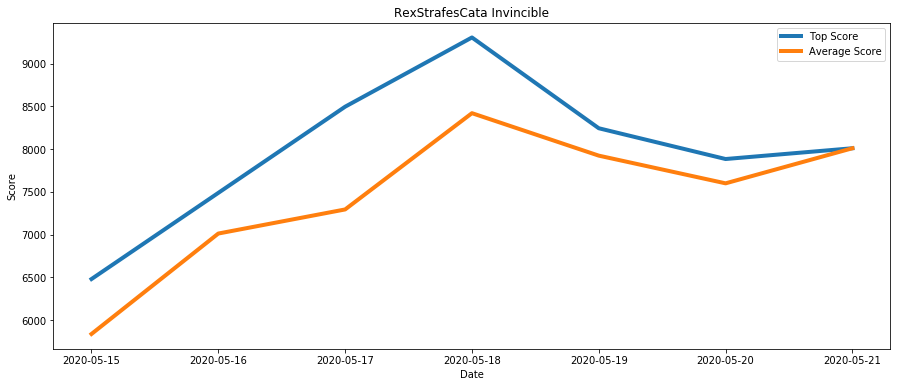

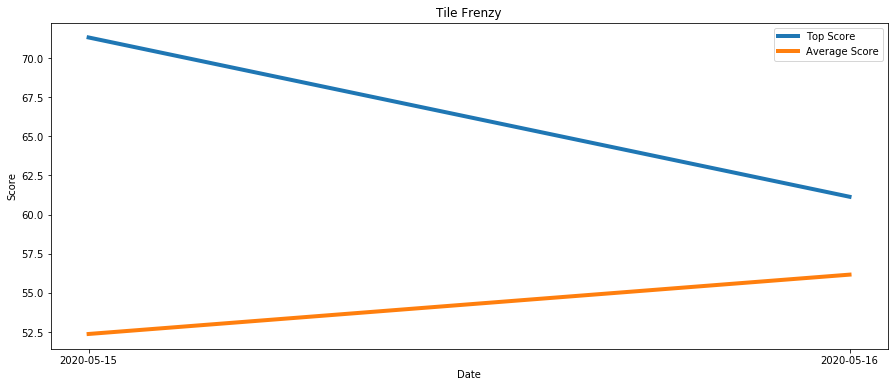

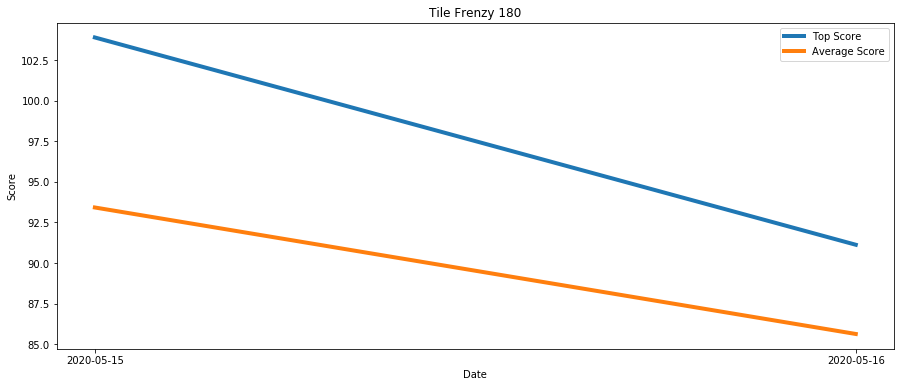

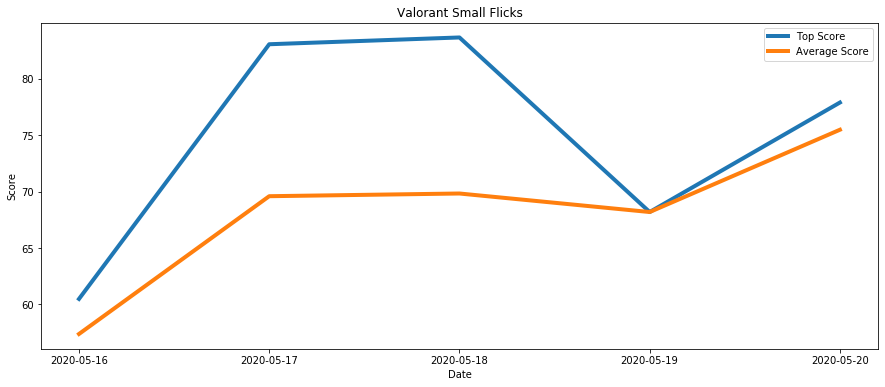

In [625]:
for scenario in scenarioList:
    topDf = scenario.generateDataframe(valueType = 'top')
    avgDf = scenario.generateDataframe(valueType = 'avg')
    
    if not topDf is None:
        topDf.rename(columns = {'Score':'Top Score'}, inplace = True)
        avgDf.rename(columns = {'Score':'Average Score'}, inplace = True)
    
        topDf = topDf.merge(avgDf, left_index = True, right_index = True)
        print(topDf)
        graph(topDf, 'line', scenario.name, scenario.datesList, 'Score', 15, 6)

In [ ]:
for line in scenarioList[1].keyList:
    print('{} : {}'.format(line, scenarioList[1].scores[line]))